# Visual Question Answering in gluon

This is a notebook for implementing visual question answering in gluon.

In [76]:
import mxnet as mx
from __future__ import print_function
import numpy as np
import mxnet as mx
import mxnet.ndarray as F
import mxnet.gluon as gluon
from mxnet.gluon import nn
from mxnet import autograd
import bisect
from IPython.core.display import display, HTML
import logging
logging.basicConfig(level=logging.INFO)
import os
from mxnet.test_utils import download
import json

## The VQA dataset

In the VQA dataset, for each sample, there is one image and one question. The label is the answer for the question regarding the image. You can download the VQA1.0 dataset from <a href="http://www.visualqa.org/vqa_v1_download.html">VQA</a>. 


You need to preprocess the data:(1) Extract the samples from original json files. (2) Filter the samples giving top k answers(k can be 1000, 2000...). 

Usually people use pretrained models to extract vector features from the image and question: Resnet152 for image and skipthought for question.

## Data Iterator

The inputs of the data iterator are extracted image and question features. At each step, the data iterator will return a data batch list: question data batch and image data batch. 

In [77]:
class VQAtrainIter(mx.io.DataIter):
    def __init__(self, img, sentences, answer, batch_size, buckets=None, invalid_label=-1,
                 text_name='text', img_name = 'image', label_name='softmax_label', dtype='float32', layout='NTC'):
        super(VQAtrainIter, self).__init__()
        if not buckets:
            buckets = [i for i, j in enumerate(np.bincount([len(s) for s in sentences]))
                       if j >= batch_size]
        buckets.sort()

        ndiscard = 0
        self.data = [[] for _ in buckets]
        for i in range(len(sentences)):
            buck = bisect.bisect_left(buckets, len(sentences[i]))
            if buck == len(buckets):
                ndiscard += 1
                continue
            buff = np.full((buckets[buck],), invalid_label, dtype=dtype)
            buff[:len(sentences[i])] = sentences[i]
            self.data[buck].append(buff)

        self.data = [np.asarray(i, dtype=dtype) for i in self.data]
        self.answer = answer
        self.img = img
        print("WARNING: discarded %d sentences longer than the largest bucket."%ndiscard)

        self.batch_size = batch_size
        self.buckets = buckets
        self.text_name = text_name
        self.img_name = img_name
        self.label_name = label_name
        self.dtype = dtype
        self.invalid_label = invalid_label
        self.nd_text = []
        self.nd_img = []
        self.ndlabel = []
        self.major_axis = layout.find('N')
        self.default_bucket_key = max(buckets)

        if self.major_axis == 0:
            self.provide_data = [(text_name, (batch_size, self.default_bucket_key)),
                                 (img_name, (batch_size, self.default_bucket_key))]
            self.provide_label = [(label_name, (batch_size, self.default_bucket_key))]
        elif self.major_axis == 1:
            self.provide_data = [(text_name, (self.default_bucket_key, batch_size)),
                                 (img_name, (self.default_bucket_key, batch_size))]
            self.provide_label = [(label_name, (self.default_bucket_key, batch_size))]
        else:
            raise ValueError("Invalid layout %s: Must by NT (batch major) or TN (time major)")

        self.idx = []
        for i, buck in enumerate(self.data):
            self.idx.extend([(i, j) for j in range(0, len(buck) - batch_size + 1, batch_size)])
        self.curr_idx = 0

        self.reset()

    def reset(self):
        self.curr_idx = 0
        self.nd_text = []
        self.nd_img = []
        self.ndlabel = []
        for buck in self.data:
            label = np.empty_like(buck.shape[0])
            label = self.answer
            self.nd_text.append(mx.ndarray.array(buck, dtype=self.dtype))
            self.nd_img.append(mx.ndarray.array(self.img, dtype=self.dtype))
            self.ndlabel.append(mx.ndarray.array(label, dtype=self.dtype))

    def next(self):
        if self.curr_idx == len(self.idx):
            raise StopIteration
        i, j = self.idx[self.curr_idx]
        self.curr_idx += 1

        if self.major_axis == 1:
            img = self.nd_img[i][j:j + self.batch_size].T
            text = self.nd_text[i][j:j + self.batch_size].T
            label = self.ndlabel[i][j:j+self.batch_size]
        else:
            img = self.nd_img[i][j:j + self.batch_size]
            text = self.nd_text[i][j:j + self.batch_size]
            label = self.ndlabel[i][j:j+self.batch_size]
        
        data = [text, img]
        return mx.io.DataBatch(data, [label],
                         bucket_key=self.buckets[i],
                         provide_data=[(self.text_name, text.shape),(self.img_name, img.shape)],
                         provide_label=[(self.label_name, label.shape)])

## Load the data

Here we will use 1/10 of the VQA training data and 1/100 of the validation data to explain the model since the data is very large. We extract the image feature from ResNet-152, text feature from GNMT encoder. We have 21537 training samples and 1044 validation samples. Image feature is a 2048-dim vector. Question feature is a 1048-dim vector.

In [78]:
demo = False
dataset_files = {'train': ('train_question.npz','train_img.npz','train_ans.npz'),
                 'validation': ('val_question.npz','val_img.npz','val_ans.npz'),
                'test':('test_question_id.npz','test_question.npz','test_img_id.npz','test_img.npz','atoi.json','test_question_txt.json')}
if demo:
    train_q, train_i, train_a = dataset_files['validation']
else:
    train_q, train_i, train_a = dataset_files['train']
val_q, val_i, val_a = dataset_files['validation']

url_format = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/{}'
if not os.path.exists(train_q):
    logging.info('Downloading training dataset.')
    download(url_format.format(train_q),overwrite=True)
    download(url_format.format(train_i),overwrite=True)
    download(url_format.format(train_a),overwrite=True)
if not os.path.exists(val_q):
    logging.info('Downloading validation dataset.')
    download(url_format.format(val_q),overwrite=True)
    download(url_format.format(val_i),overwrite=True)
    download(url_format.format(val_a),overwrite=True)


In [79]:
batch_size = 64
layout = 'NT'
bucket = [1024]

if demo:
    train_question = np.load("val_question.npz")['x']
    val_question = np.load("val_question.npz")['x']
    train_ans = np.load("val_ans.npz")['x']
    val_ans = np.load("val_ans.npz")['x']
    train_img = np.load("val_img.npz")['x']
    val_img = np.load("val_img.npz")['x']
else:
    train_question = np.load("train_question.npz")['x']
    val_question = np.load("val_question.npz")['x']
    train_ans = np.load("train_ans.npz")['x']
    val_ans = np.load("val_ans.npz")['x']
    train_img = np.load("train_img.npz")['x']
    val_img = np.load("val_img.npz")['x']


data_train  = VQAtrainIter(train_img, train_question, train_ans, batch_size, buckets = bucket,layout=layout)
data_eva = VQAtrainIter(val_img, val_question, val_ans, batch_size, buckets = bucket,layout=layout) 

## Define the model

gluon.Block is the basic building block of models. If any operator is not defined under gluon, you can use mxnet.ndarray operators to subsititude.

In [80]:
class Net(gluon.Block):
    def __init__(self, **kwargs):
        super(Net, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.bn = nn.BatchNorm()
            self.dropout = nn.Dropout(0.3)
            self.fc1 = nn.Dense(8192,activation="relu")
            self.fc2 = nn.Dense(1000)
            

    def forward(self, x):
        x1 = F.L2Normalization(x[0])
        x2 = F.L2Normalization(x[1])
        z = F.concat(x1,x2,dim=1)
        z = self.fc1(z)
        z = self.bn(z)
        z = self.dropout(z)
        z = self.fc2(z)
        return z


## Initialize the Parameters

In [81]:
ctx = mx.gpu(2)
net = Net()
# Initialize on CPU. Replace with `mx.gpu(0)`, or `[mx.gpu(0), mx.gpu(1)]`,
# etc to use one or more GPUs.
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

## Loss

In [82]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

## Evaluation Metrics

In [83]:
metric = mx.metric.Accuracy()

def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    
    data_iterator.reset()
    for i, batch in enumerate(data_iterator):
        with autograd.record():
            data1 = batch.data[0].as_in_context(ctx)
            data2 = batch.data[1].as_in_context(ctx)
            data = [data1,data2]
            label = batch.label[0].as_in_context(ctx)
            #label_one_hot = nd.one_hot(label, 10)
            output = net(data)
        
        metric.update([label], [output])
    return metric.get()[1]


## Optimizer

In [84]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})

## Training loop

In [85]:
epochs = 10
moving_loss = 0.
best_eva = 0
for e in range(epochs):
    data_train.reset()
    for i, batch in enumerate(data_train):
        data1 = batch.data[0].as_in_context(ctx)
        data2 = batch.data[1].as_in_context(ctx)
        data = [data1,data2]
        label = batch.label[0].as_in_context(ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
            cross_entropy.backward()
        trainer.step(data[0].shape[0])
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        if i == 0:
            moving_loss = np.mean(cross_entropy.asnumpy()[0])
        else:
            moving_loss = .99 * moving_loss + .01 * np.mean(cross_entropy.asnumpy()[0])
        #if i % 200 == 0:
        #    print("Epoch %s, batch %s. Moving avg of loss: %s" % (e, i, moving_loss))   
    eva_accuracy = evaluate_accuracy(data_eva, net)
    train_accuracy = evaluate_accuracy(data_train, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Eval_acc %s" % (e, moving_loss, train_accuracy, eva_accuracy))
    if eva_accuracy > best_eva:
            best_eva = eva_accuracy
            logging.info('Best validation acc found. Checkpointing...')
            net.save_params('vqa-mlp-%d.params'%(e))


INFO:root:Best validation acc found. Checkpointing...


Epoch 0. Loss: 2.91646247964, Train_acc 0.442471590909, Eval_acc 0.3671875


INFO:root:Best validation acc found. Checkpointing...


Epoch 1. Loss: 2.01777334363, Train_acc 0.478670987216, Eval_acc 0.439028532609


INFO:root:Best validation acc found. Checkpointing...


Epoch 2. Loss: 1.5727014, Train_acc 0.515403053977, Eval_acc 0.476497395833


INFO:root:Best validation acc found. Checkpointing...


Epoch 3. Loss: 1.3318601549, Train_acc 0.547085848722, Eval_acc 0.513482392724


INFO:root:Best validation acc found. Checkpointing...


Epoch 4. Loss: 1.24547814717, Train_acc 0.578311434659, Eval_acc 0.545360779494


INFO:root:Best validation acc found. Checkpointing...


Epoch 5. Loss: 0.980275953307, Train_acc 0.605675899621, Eval_acc 0.576884501689


INFO:root:Best validation acc found. Checkpointing...


Epoch 6. Loss: 0.819638218146, Train_acc 0.629800375406, Eval_acc 0.604161771617


INFO:root:Best validation acc found. Checkpointing...


Epoch 7. Loss: 0.70657918158, Train_acc 0.650346235795, Eval_acc 0.628257308468


INFO:root:Best validation acc found. Checkpointing...


Epoch 8. Loss: 0.602496707366, Train_acc 0.669315222538, Eval_acc 0.64890095339


INFO:root:Best validation acc found. Checkpointing...


Epoch 9. Loss: 0.573524168892, Train_acc 0.685555752841, Eval_acc 0.667895139761


## Try it out!

We can try it on test data. Here we have 10 test samples. 

In [86]:
test = True
if test:
    test_q_id, test_q, test_i_id, test_i, atoi,text = dataset_files['test']

if test and not os.path.exists(test_q):     
    logging.info('Downloading test dataset.')
    download(url_format.format(test_q_id),overwrite=True)
    download(url_format.format(test_q),overwrite=True)
    download(url_format.format(test_i_id),overwrite=True)
    download(url_format.format(test_i),overwrite=True)
    download(url_format.format(atoi),overwrite=True)
download(url_format.format(text),overwrite=True)

if test:
    test_question = np.load("test_question.npz")['x']
    test_img = np.load("test_img.npz")['x']
    test_question_id = np.load("test_question_id.npz")['x']
    test_img_id = np.load("test_img_id.npz")['x']
    #atoi = np.load("atoi.json")['x']
    


INFO:root:downloaded https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/test_question_txt.json into test_question_txt.json successfully


We pass the test data iterator to the trained model.

In [87]:
data_test = VQAtrainIter(test_img, test_question, np.zeros((test_img.shape[0],1)), 10, buckets = bucket,layout=layout)
for i, batch in enumerate(data_test):
    with autograd.record():
        data1 = batch.data[0].as_in_context(ctx)
        data2 = batch.data[1].as_in_context(ctx)
        data = [data1,data2]
        #label = batch.label[0].as_in_context(ctx)
        #label_one_hot = nd.one_hot(label, 10)
        output = net(data)
output = np.argmax(output.asnumpy(), axis = 1)

In [88]:
idx = np.random.randint(10)
print(idx)
question = json.load(open(text))
print("Question:", question[idx])

8
Question: Are there any people at the train boarding station?


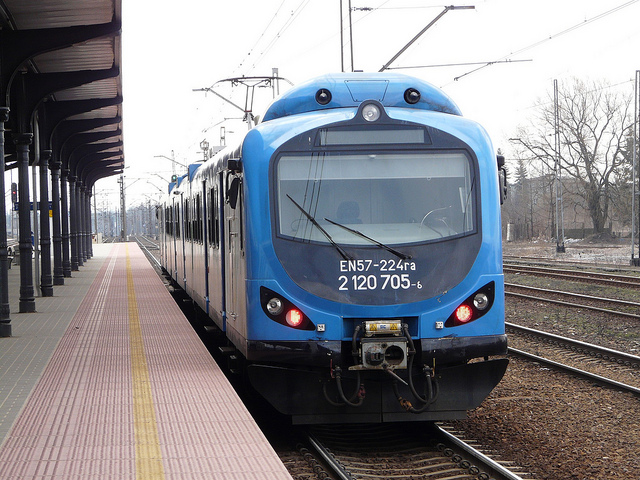

In [89]:
image_name = 'COCO_test2015_' + str(int(test_img_id[idx])).zfill(12)+'.jpg'
if not os.path.exists(image_name):
    logging.info('Downloading training dataset.')
    download(url_format.format('test_images/'+image_name),overwrite=True)

from IPython.display import Image
Image(filename=image_name) 

In [90]:
dataset = json.load(open('atoi.json'))
ans = dataset['ix_to_ans'][str(output[idx]+1)]
print("Answer:", ans)

Answer: no
